In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import csv
import shapely
import shapely.wkt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
import numpy as np
import geopy
from datetime import datetime
import os, csv, shapely, shapely.wkt, descartes, geopy, pickle, cloudpickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.options.display.float_format = '{:.4f}'.format
import seaborn as sns
import matplotlib.pyplot as plt
import descartes
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn import metrics as skm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from fairlearn.metrics import equalized_odds_ratio, MetricFrame, demographic_parity_difference, demographic_parity_ratio, selection_rate, equalized_odds_difference, true_positive_rate, false_positive_rate
from fairlearn.reductions import BoundedGroupLoss, ZeroOneLoss, ExponentiatedGradient, SquareLoss, AbsoluteLoss, GridSearch, DemographicParity, ErrorRate, EqualizedOdds
from sklearn.model_selection import KFold
from itertools import repeat

# pd.set_option('display.max_rows', 10)
# sns.set()
# sns.color_palette("ch:s=.25,rot=-.25")
np.set_printoptions(suppress=True)


Bad key "text.kerning_factor" on line 4 in
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
CITY = "P_"
save_dir = CITY + 'clas_res/'
save_dir_preprocess = os.path.join(save_dir, CITY + 'preprocess_fig/')
save_dir_models = os.path.join(save_dir, CITY + 'model_res/') 
save_dir_forecast = os.path.join(save_dir, CITY + 'forecast/')
save_dir_fairst = os.path.join(save_dir, CITY + 'fairst/')

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
if not os.path.exists(save_dir_preprocess):
    os.makedirs(save_dir_preprocess)

if not os.path.exists(save_dir_models):
    os.makedirs(save_dir_models)
    
if not os.path.exists(save_dir_forecast):
    os.makedirs(save_dir_forecast)
    
if not os.path.exists(save_dir_fairst):
    os.makedirs(save_dir_fairst)

In [3]:
# load two datasets
df_pgh = pd.read_csv("data/pgh_grid_census.csv", index_col = 0)
df_spatially = pd.read_csv("data/spatially_sensitive_train.csv", index_col = 0)

censusTract = gpd.read_file('data/2010_Census_Tracts/a36fc9b1-4e53-4fd1-80fb-db1554e213422020328-1-nbfxcj.l6b8.shp')
geo_df = pd.read_csv("data/pgh_grid_fit.csv")[["cell_num", "geometry", "centroid"]]
geo_df.to_csv(os.path.join(save_dir_forecast, CITY +"geo_df.csv"))
geo_df.head()

,cell_num,geometry,centroid
0,51,"POLYGON ((-80.0953367046031 40.44883540123336,...",POINT (-80.09304131033451 40.45113079550194)
1,52,"POLYGON ((-80.0953367046031 40.45342618977051,...",POINT (-80.09304131033451 40.45572158403908)
2,82,POLYGON ((-80.09074591606594 40.44424461269621...,POINT (-80.08845052179737 40.44654000696479)
3,83,POLYGON ((-80.09074591606594 40.44883540123336...,POINT (-80.08845052179737 40.45113079550194)
4,84,POLYGON ((-80.09074591606594 40.45342618977051...,POINT (-80.08845052179737 40.45572158403908)


### plot station distribution

In [4]:
df_pgh_temp = df_pgh[["cell_num", "stations"]]
df_spatially_temp = df_spatially[["cell_num", "stations"]]

stations_dict = {}

for s in df_spatially_temp["cell_num"].unique():
    # print(df_spatially_temp[df_spatially_temp["cell_num"] == 628])
    stations_dict[s] = df_spatially_temp[df_spatially_temp["cell_num"] == s].iloc[-1]["stations"]
    
for stations in df_pgh_temp["cell_num"].unique():
    if stations not in stations_dict.keys():
        stations_dict[stations] = 0
        
geo_df["stations"] = 0

for index, row in geo_df.iterrows():
    row["stations"] = stations_dict[row["cell_num"]]
    geo_df.iloc[index] = row
    
for row,col in geo_df.iterrows():
    geo_df.at[row, 'geometry'] = shapely.wkt.loads(geo_df.loc[row]['geometry'])
    geo_df.at[row, 'centroid'] = shapely.wkt.loads(geo_df.loc[row]['centroid'])

Text(0.5, 1, 'Distribution of number of stations')

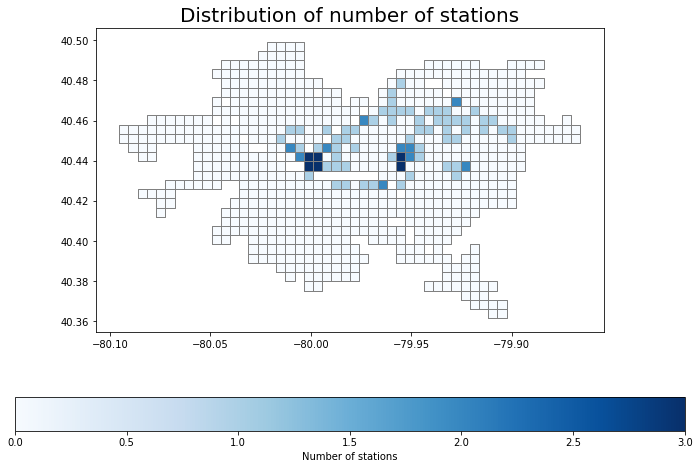

In [5]:
geo_df = gpd.GeoDataFrame(geo_df, crs='EPSG:2956', geometry='geometry')
# type(pgh_grid_income.loc[0]['geometry'])

geo_df.plot(column="stations", cmap='Blues',edgecolor = "grey", figsize=(12, 8),  
                    legend = True, legend_kwds={'label': "Number of stations",'orientation': "horizontal"})
plt.title("Distribution of number of stations", fontsize=20)
# plt.savefig(os.path.join(save_dir_preprocess, CITY +"stations_dist"), facecolor = 'w')

### outflow transform

In [6]:
df_outflow = df_spatially[["cell_num", "year", "month", "outflow"]]
df_outflow

,cell_num,year,month,outflow
0,687,2018,JUL,1
1,687,2018,AUG,0
2,687,2018,SEP,0
3,687,2018,OCT,0
4,687,2018,NOV,0
...,...,...,...,...
3340,1396,2020,AUG,9
3341,1396,2020,SEP,10
3342,1396,2020,OCT,6
3343,1396,2020,NOV,3


In [7]:
def month_trans(m):
    month_num_dict = {"JAN": 1, "FEB": 2, "MAR": 3, "APR": 4,
                     "MAY": 5, "JUN": 6, "JUL": 7, "AUG": 8,
                     "SEP": 9, "OCT": 10, "NOV": 11, "DEC": 12}
    
    return month_num_dict[m]

df_outflow["month"] = df_outflow["month"].apply(lambda x: month_trans(x))
df_outflow

/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,cell_num,year,month,outflow
0,687,2018,7,1
1,687,2018,8,0
2,687,2018,9,0
3,687,2018,10,0
4,687,2018,11,0
...,...,...,...,...
3340,1396,2020,8,9
3341,1396,2020,9,10
3342,1396,2020,10,6
3343,1396,2020,11,3


In [8]:
outflow_complete = df_outflow

### weather

In [9]:
df_weather_raw = pd.read_csv("data/weatherpgh.csv")
df_weather_raw = df_weather_raw[df_weather_raw.YEAR.isin([2015, 2016, 2017, 2018, 2019])].reset_index(drop = True)
df_weather_raw.index = df_weather_raw.YEAR
df_weather_raw.drop(columns = ["YEAR"], inplace = True)

In [10]:
df_weather_temp = pd.DataFrame(index = np.arange(12), columns = [2015, 2016, 2017, 2018, 2019])

for index, row in df_weather_raw.iterrows():
    df_weather_temp[index] = row.values[:-1]

    year_l = [2015, 2016, 2017, 2018, 2019]
month_l = list(np.arange(12) + 1)

df_weather_final = pd.DataFrame(index = np.arange(60), columns = ["temp"])
df_weather_final["year"] = [x for item in year_l for x in repeat(item, 12)]
df_weather_final["month"] = month_l*5
df_weather_final.drop(index = [0, 1, 2, 3]).reset_index(drop = True, inplace = True)
df_weather_final.head()

,temp,year,month
0,NaN,2015,1
1,NaN,2015,2
2,NaN,2015,3
3,NaN,2015,4
4,NaN,2015,5


In [11]:
for index, row in df_weather_final.iterrows():
    year = row.year
    month = row.month
    df_weather_final.loc[index, "temp"] = df_weather_temp.loc[month-1, year]
    
df_weather_final.to_csv(os.path.join(save_dir_forecast, CITY +"df_weather_final.csv"))

df_merge1 = outflow_complete.merge(df_weather_final, on = ["year", 'month'], how = 'left')

### walk score dataset

In [12]:
# load two datasets
df_walk_score = df_spatially[["cell_num", "stations", "capacity", "walk_score", "bike_score", "transit_score", "nearby"]]
# extract parts from "nearby"

df_walk_score['nearby_bus'] = 0
df_walk_score['nearby_rail'] = 0
df_walk_score['nearby_other'] = 0
df_walk_score['nearby_routes'] = 0

for row,col in df_walk_score.iterrows():
    # if nearby == NaN
    if type(df_walk_score.loc[row]['nearby']) == float:
        df_walk_score.at[row, 'nearby_bus'] = 0
        df_walk_score.at[row, 'nearby_rail'] = 0
        df_walk_score.at[row, 'nearby_other'] = 0
        
    else:
        routes = df_walk_score.loc[row]['nearby']
        routes = routes.split(' ')
        nearby_routes = routes[0]
        nearby_bus = routes[3]
        nearby_rail = routes[5]
        nearby_other = routes[7]

        df_walk_score.at[row, 'nearby_bus'] = nearby_bus
        df_walk_score.at[row, 'nearby_rail'] = nearby_rail
        df_walk_score.at[row, 'nearby_other'] = nearby_other
        df_walk_score.at[row, 'nearby_routes'] = nearby_routes
        
df_walk_score.drop(columns = ["nearby"], inplace = True)
df_walk_score.reset_index(drop = True, inplace = True)

# censusTract

df_walk_score_temp = df_walk_score.groupby("cell_num").mean().reset_index()
for col in df_walk_score_temp.columns:
    df_walk_score_temp[col] = df_walk_score_temp[col].astype(int)
df_walk_score_temp.head()

/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yhannnn/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,cell_num,stations,capacity,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,595,1,19,73,66,71,38,3,0,41
1,626,2,36,62,75,92,86,3,2,91
2,628,1,5,77,87,68,52,3,0,55
3,657,2,21,98,84,99,86,3,2,91
4,658,1,15,88,80,97,87,3,2,92


In [13]:
df_merge2 = df_merge1.merge(df_walk_score_temp, on = 'cell_num', how = "left")
df_merge2

,cell_num,year,month,outflow,temp,stations,capacity,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes
0,687,2018,7,1,73.5000,1,10,76,82,86,58,3,2,63
1,687,2018,8,0,73.0000,1,10,76,82,86,58,3,2,63
2,687,2018,9,0,69.7000,1,10,76,82,86,58,3,2,63
3,687,2018,10,0,53.4000,1,10,76,82,86,58,3,2,63
4,687,2018,11,0,37.3000,1,10,76,82,86,58,3,2,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3340,1396,2020,8,9,NaN,1,7,60,74,63,26,0,0,26
3341,1396,2020,9,10,NaN,1,7,60,74,63,26,0,0,26
3342,1396,2020,10,6,NaN,1,7,60,74,63,26,0,0,26
3343,1396,2020,11,3,NaN,1,7,60,74,63,26,0,0,26


### census tract dataset

In [14]:
# for forecast
df_station_cap = df_spatially[["cell_num", "stations", "capacity"]].groupby("cell_num").mean().reset_index()
df_station_cap.stations = df_station_cap.stations.astype(int)
df_station_cap.capacity = df_station_cap.capacity.astype(int)
df_station_cap.to_csv(os.path.join(save_dir_forecast, CITY +"df_station_cap.csv"))

In [15]:
df_pgh_census = df_pgh[["cell_num", "median_hh_income", "population_16yrs+", "total_households", "mean_travel_time_to_work",
        "Workers_16yrs+", "perc_public", "perc_walk", "perc_other", "perc_employed", 
        "perc_unemployed", "wfh", "own_alone", "carpool"]]
df_pgh_census.to_csv(os.path.join(save_dir_forecast, CITY +"df_pgh_census.csv"))
df_pgh_census

,cell_num,median_hh_income,population_16yrs+,total_households,mean_travel_time_to_work,Workers_16yrs+,perc_public,perc_walk,perc_other,perc_employed,perc_unemployed,wfh,own_alone,carpool
0,51,67409,2660,1306,23,1695,0.1563,0.0372,0.0000,0.6346,0.0481,58,1083,226
1,52,67409,2660,1306,23,1695,0.1563,0.0372,0.0000,0.6346,0.0481,58,1083,226
2,82,67409,2660,1306,23,1695,0.1563,0.0372,0.0000,0.6346,0.0481,58,1083,226
3,83,67409,2660,1306,23,1695,0.1563,0.0372,0.0000,0.6346,0.0481,58,1083,226
4,84,67409,2660,1306,23,1695,0.1563,0.0372,0.0000,0.6346,0.0481,58,1083,226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,1587,30089,2394,1391,26,1066,0.1811,0.0000,0.0000,0.4628,0.0706,179,581,113
724,1588,30089,2394,1391,26,1066,0.1811,0.0000,0.0000,0.4628,0.0706,179,581,113
725,1589,30089,2394,1391,26,1066,0.1811,0.0000,0.0000,0.4628,0.0706,179,581,113
726,1619,30089,2394,1391,26,1066,0.1811,0.0000,0.0000,0.4628,0.0706,179,581,113


In [16]:
df = df_merge2.merge(df_pgh_census, on = "cell_num", how = 'left')
df = df.fillna(0)
df

,cell_num,year,month,outflow,temp,stations,capacity,walk_score,bike_score,transit_score,nearby_bus,nearby_rail,nearby_other,nearby_routes,median_hh_income,population_16yrs+,total_households,mean_travel_time_to_work,Workers_16yrs+,perc_public,perc_walk,perc_other,perc_employed,perc_unemployed,wfh,own_alone,carpool
0,687,2018,7,1,73.5000,1,10,76,82,86,58,3,2,63,-,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0
1,687,2018,8,0,73.0000,1,10,76,82,86,58,3,2,63,-,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0
2,687,2018,9,0,69.7000,1,10,76,82,86,58,3,2,63,-,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0
3,687,2018,10,0,53.4000,1,10,76,82,86,58,3,2,63,-,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0
4,687,2018,11,0,37.3000,1,10,76,82,86,58,3,2,63,-,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3340,1396,2020,8,9,0.0000,1,7,60,74,63,26,0,0,26,15299,1003,694,28,310,0.3419,0.0516,0.0000,0.3091,0.0080,28,160,0
3341,1396,2020,9,10,0.0000,1,7,60,74,63,26,0,0,26,15299,1003,694,28,310,0.3419,0.0516,0.0000,0.3091,0.0080,28,160,0
3342,1396,2020,10,6,0.0000,1,7,60,74,63,26,0,0,26,15299,1003,694,28,310,0.3419,0.0516,0.0000,0.3091,0.0080,28,160,0
3343,1396,2020,11,3,0.0000,1,7,60,74,63,26,0,0,26,15299,1003,694,28,310,0.3419,0.0516,0.0000,0.3091,0.0080,28,160,0


In [17]:
df["median_hh_income"] = df["median_hh_income"].replace("-", 0)
df.median_hh_income = df.median_hh_income.astype(int)

### income

In [18]:
print(df["median_hh_income"].describe())

count     3345.0000
mean     53813.6637
std      31303.4149
min          0.0000
25%      27003.0000
50%      54457.0000
75%      69491.0000
max     133750.0000
Name: median_hh_income, dtype: float64


In [19]:
# training set
df["income_group"] = 0
for row, col in df.iterrows():
    if df.loc[row]["median_hh_income"] > 50000:
        df.at[row, "income_group"] = 1
df.drop(columns = ["median_hh_income"], inplace = True)

Text(0, 0.5, 'Count')

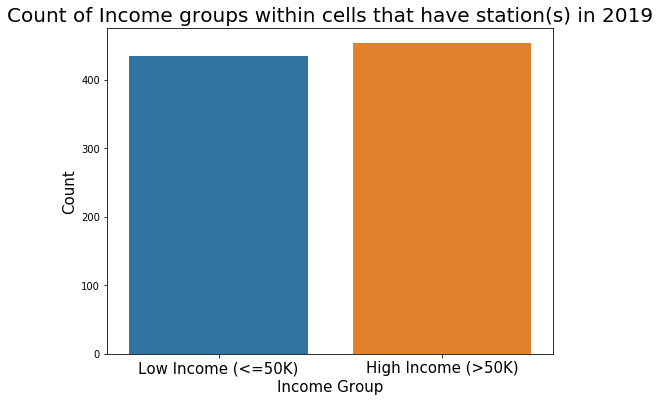

In [20]:
plt.figure(figsize = (8, 6))
sns.countplot(df[df.year == 2019]["income_group"])
plt.title("Count of Income groups within cells that have station(s) in 2019", fontsize = 20)
plt.xticks([0, 1], ["Low Income (<=50K)", "High Income (>50K)"], fontsize = 15)
plt.xlabel("Income Group", fontsize = 15)
plt.ylabel("Count", fontsize = 15)
# plt.savefig(os.path.join(save_dir_preprocess, CITY +"income_group_2019"))

### outflow class

In [21]:
df["outflow_class"] = 0
for row, col in df.iterrows():
        
    if df.loc[row]["outflow"] > df.outflow.mean():
        df.at[row, "outflow_class"] = 1
        
df.drop(columns = ["outflow"], inplace = True)

Text(0.5, 1.0, 'Distrbution of outflow classes with income classess in 2019')

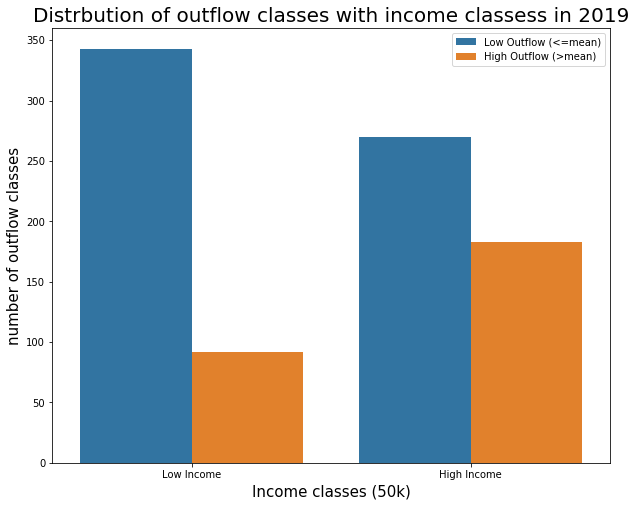

In [22]:
# sns.set(rc={'figure.figsize':(8, 6)})
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.countplot(df[df.year == 2019]['income_group'], hue = df[df.year == 2019]["outflow_class"])
# ax.set_title('Count of outflow classes for two income groups')
ax.set_ylabel('number of outflow classes', fontsize = 15)
ax.set_xlabel("Income classes (50k)", fontsize = 15)
plt.legend(["Low Outflow (<=mean)", "High Outflow (>mean)"])

# # plt.savefig("fig1")
plt.xticks([0, 1], ['Low Income', 'High Income'])
plt.title("Distrbution of outflow classes with income classess in 2019", fontsize = 20)
# plt.savefig(os.path.join(save_dir_preprocess, CITY+"outflow_income_group_2019"))

In [23]:
df_low_income = df[df.year == 2019][df[df.year == 2019]["income_group"] == 0]
df_high_income = df[df.year == 2019][df[df.year == 2019]["income_group"] == 1]

low_income_low_outflow = len(df_low_income[df_low_income["outflow_class"] == 0])/len(df_low_income)
low_income_high_outflow = len(df_low_income[df_low_income["outflow_class"] == 1])/len(df_low_income)

high_income_low_outflow = len(df_high_income[df_high_income["outflow_class"] == 0])/len(df_high_income)
high_income_high_outflow = len(df_high_income[df_high_income["outflow_class"] == 1])/len(df_high_income)

fig2_df = pd.DataFrame({"Outflow": [low_income_high_outflow*100, high_income_high_outflow*100],
                       "Income": ["Low", "High"]})
fig2_df

,Outflow,Income
0,21.1494,Low
1,40.3974,High


Text(0.5, 1.0, 'Percentage of high outflow classes in 2019')

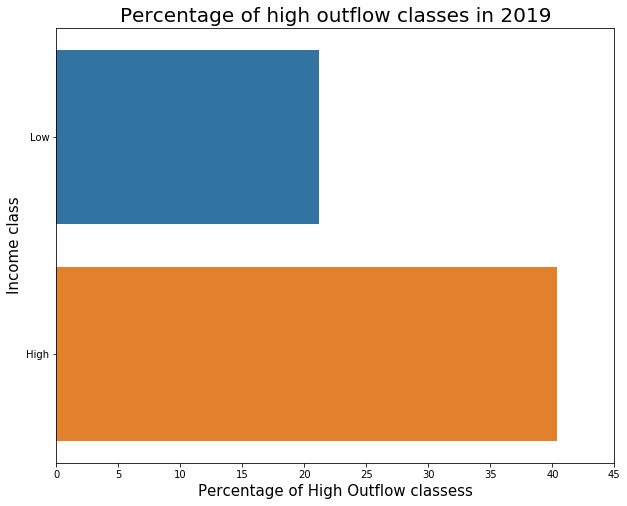

In [24]:
# sns.set(rc={'figure.figsize':(8, 6)})
fig, ax = plt.subplots(figsize = (10, 8))
ax = sns.barplot(data = fig2_df, x = 'Outflow', y = 'Income')

ax.set_ylabel('Income class', fontsize = 15)
ax.set_xlabel("Percentage of High Outflow classess", fontsize = 15)
ax.set_xlim(0, 45)
plt.title("Percentage of high outflow classes in 2019", fontsize = 20)
# plt.savefig(os.path.join(save_dir_preprocess, CITY+"outflow_income_group2_2019"))

In [25]:
# Train Test split
df_1518 = df[df["year"].isin([2015, 2016, 2017, 2018])] # 1032
df_19 = df[df["year"].isin([2019])]

df_1518 = df_1518.drop(columns = ["year"])
df_19 = df_19.drop(columns = ["year"])

In [26]:
X_train = df_1518.drop(columns = ["outflow_class", "cell_num"])
X_test = df_19.drop(columns = ["outflow_class", "cell_num"])

y_train = df_1518["outflow_class"]
y_test = df_19["outflow_class"]

A_train = df_1518["income_group"]
A_test = df_19["income_group"]

y_test_cell_num = df_19[["cell_num", "income_group"]]
y_test_cell_num

,cell_num,income_group
6,687,0
7,687,0
8,687,0
9,687,0
10,687,0
...,...,...
3328,1396,0
3329,1396,0
3330,1396,0
3331,1396,0


In [27]:
# reset index
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)
A_train.reset_index(drop = True, inplace = True)
A_test.reset_index(drop = True, inplace = True)

X_train.to_csv(os.path.join(save_dir_forecast, CITY + "X_train.csv"))

### 3 Fairness models

In [28]:
# summary df
model_summary = pd.DataFrame(0, columns = ["accuracy", "accuracy_diff", "selection_rate", "selection_rate_diff"], 
                             index = ["random_forest", "exp_grad", "grid_search"])

# model_summary.to_csv(os.path.join(save_dir_models, "model_summary.csv"))

In [29]:
rf_best = pickle.load(open(os.path.join(save_dir_models, CITY + "random_forest.pkl"), 'rb'))

accuracy         0.8615
selection_rate   0.2545
dtype: object
------------------------------
             accuracy selection_rate
income_group                        
0              0.8529         0.1287
1              0.8698         0.3753
------------------------------
accuracy: 0.86149
accuracy diff: 0.01688
selection_rate: 0.25450
selection_rate diff: 0.24654
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ce4d9bc90>,
      dtype=object)

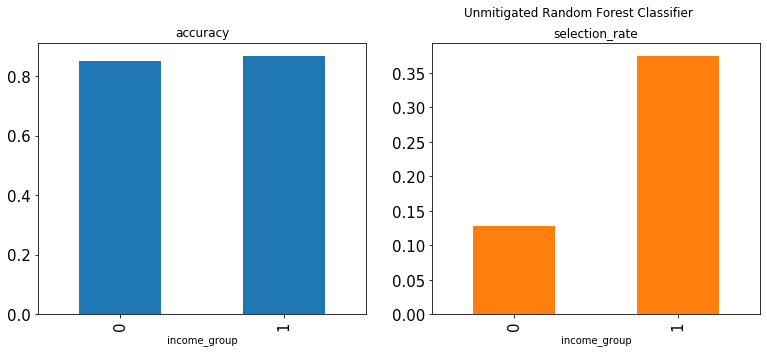

In [30]:
'''
TEST SET
'''
# rf_best = grid_search.best_estimator_
rf_best.fit(X_train, y_train)
y_pred_rf_gs = rf_best.predict(X_test)

# Metric evaluation
metric_frame_rf_gs = MetricFrame(metric = 
                                    {"accuracy": skm.accuracy_score,
                                     "selection_rate": selection_rate},
                                   sensitive_features = A_test,
                                   y_true = y_test,
                                   y_pred = y_pred_rf_gs)

print(metric_frame_rf_gs.overall)
print("-"*30)
print(metric_frame_rf_gs.by_group)
print("-"*30)
print("accuracy:", "{:.5f}".format(metric_frame_rf_gs.overall["accuracy"]))
print("accuracy diff:", "{:.5f}".format(metric_frame_rf_gs.difference()["accuracy"]))
print("selection_rate:", "{:.5f}".format(metric_frame_rf_gs.overall["selection_rate"]))
print("selection_rate diff:", "{:.5f}".format(metric_frame_rf_gs.difference()["selection_rate"]))

print("-"*30)
model_summary.loc["random_forest", "accuracy"] = metric_frame_rf_gs.overall["accuracy"]
model_summary.loc["random_forest", "accuracy_diff"] = metric_frame_rf_gs.difference()["accuracy"]
model_summary.loc["random_forest", "selection_rate"] = metric_frame_rf_gs.overall["selection_rate"]
model_summary.loc["random_forest", "selection_rate_diff"] = metric_frame_rf_gs.difference()["selection_rate"]

# # save model
# model_summary.loc["random_forest", "r2"] = metric_frame_rf_gs.overall["R^2"]
# model_summary.loc["random_forest", "mae"] = metric_frame_rf_gs.overall["MAE"]
# model_summary.loc["random_forest", "r2_diff"] = metric_frame_rf_gs.difference()["R^2"]
# model_summary.loc["random_forest", "mae_diff"] = metric_frame_rf_gs.difference()["MAE"]
# model_summary.loc["random_forest", "rfg"] = rfg_calc(y_pred_rf_gs, y_test, normalized_pop_df, y_test_cell_num)

# plot
metric_frame_rf_gs.by_group.plot.bar(
        subplots=True, layout=[1, 3], legend=False, figsize=[20, 5],
        title='Unmitigated Random Forest Classifier', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY +"random_forest_metrics"))

### 3.2 Exponentiated Gradient (constraint: EqualizedOdds)

In [32]:
# diff_bound_l = np.arange(0, 100000, 2000)/10000000
# diff_bound_l = diff_bound_l[1:]
# diff_bound_l = [0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5]

diff_bound_l = np.linspace(0, 1, 100)
# diff_bound_l = [0.1, 0.2, 0.3, 0.4, 0.5]

In [33]:
# cross validation for EG
# implement K-fold cross validation

exp_grad_result = pd.DataFrame({"diff_bound": diff_bound_l})

for i in range(len(diff_bound_l)):
    cv_acc_ls = []
    cv_selection_rate_diff_ls = []
    
    print(i)
    diff_bound = diff_bound_l[i]
    
    # train-valid split
    kfold = KFold(3, shuffle = True, random_state = 42)
    for train, valid in kfold.split(X_train):
        # print("CV")
        X_train_exp = X_train.loc[train]
        y_train_exp = y_train.loc[train]
        A_train_exp = A_train.loc[train]

        X_valid = X_train.loc[valid]
        y_valid = y_train.loc[valid]
        A_valid = A_train.loc[valid]

        # avoid failure of optimization
        # try:
        # train
        # constraint = EqualizedOdds(difference_bound = diff_bound)
        constraint = DemographicParity(difference_bound = diff_bound)
        exp_grad = ExponentiatedGradient(estimator = rf_best, constraints = constraint)
        try:
            exp_grad.fit(X_train_exp, y_train_exp, sensitive_features = A_train_exp)
            y_valid_pred = exp_grad.predict(X_valid, random_state = 42)

            # performance validation #
            metric_frame_eg_cv = MetricFrame(metric = 
                                                    {"accuracy": skm.accuracy_score,
                                                     "selection_rate": selection_rate},
                                             sensitive_features = A_valid, 
                                             y_true = y_valid, 
                                             y_pred = y_valid_pred)

            cv_acc_ls.append(metric_frame_eg_cv.overall["accuracy"])
            cv_selection_rate_diff_ls.append(metric_frame_eg_cv.difference()["selection_rate"])

        except:
            print("na")
            cv_acc_ls.append(np.nan)
            cv_selection_rate_diff_ls.append(np.nan)
            
    exp_grad_result.loc[i, "cv_avg_acc"] = np.nanmean(np.array(cv_acc_ls))
    exp_grad_result.loc[i, "cv_selection_rate_diff"] = np.nanmean(np.array(cv_selection_rate_diff_ls))

    
    # exp_grad_result.to_csv(os.path.join(save_dir_models, CITY+"exp_grad_valid_res.csv"))

In [34]:
# best_eg_index = exp_grad_result[exp_grad_result.cv_avg_mae_diff == exp_grad_result.cv_avg_mae_diff.min()].index[0]
# print("best upper bound for BGL:", diff_bound_l[best_eg_index])

# plot
plt.figure(figsize = (25, 8))
plt.plot(exp_grad_result.diff_bound, exp_grad_result.cv_selection_rate_diff)
plt.scatter(exp_grad_result.iloc[exp_grad_result.cv_selection_rate_diff.argmin()].diff_bound, exp_grad_result.iloc[exp_grad_result.cv_selection_rate_diff.argmin()].cv_selection_rate_diff, color = "red")
# plt.scatter(x = eg_result.diff_bound, y = eg_result.MSE_diff)
plt.xlabel("diff bound", fontsize = 15)
plt.ylabel("Selection rate difference", fontsize = 15)
plt.text(x = exp_grad_result.iloc[exp_grad_result.cv_selection_rate_diff.argmin()].diff_bound+0.0005, y = exp_grad_result.iloc[exp_grad_result.cv_selection_rate_diff.argmin()].cv_selection_rate_diff, s = 'min', color = "red")
plt.title("Cross Validation MAE diff for parameter 'upper_bound' \nin Bounded Group Loss for Exponentiated Gradient", fontsize = 18)
plt.title("Exponentiated Gradient cross validation result: MAE difference vs. 'upper_bound' in BGL ", fontsize = 18)
# plt.savefig(os.path.join(save_dir_models, CITY+"exp_grad_valid_res"))

In [48]:
best_diff = exp_grad_result.loc[exp_grad_result.cv_selection_rate_diff.argmin()].diff_bound

In [49]:
# predict on test set
constraint = DemographicParity(difference_bound = best_diff)
eg_best = ExponentiatedGradient(estimator = rf_best, constraints = constraint)
eg_best.fit(X_train, y_train, sensitive_features = A_train)
y_pred_eg = eg_best.predict(X_test, random_state = 42)

In [50]:
# save model
Pkl_Filename = "exp_grad_SP.pkl"  
with open(os.path.join(save_dir_models, CITY + Pkl_Filename), 'wb') as file:  
    cloudpickle.dump(eg_best, file)

In [51]:
eg_best = pickle.load(open(os.path.join(save_dir_models, CITY + "exp_grad_SP.pkl"), 'rb'))
y_pred_eg = eg_best.predict(X_test, random_state = 42)

accuracy         0.8525
selection_rate   0.3131
dtype: object
------------------------------
             accuracy selection_rate
income_group                        
0              0.8437         0.2575
1              0.8609         0.3664
------------------------------
accuracy: 0.85248
accuracy diff: 0.01725
selection_rate: 0.31306
selection_rate diff: 0.10897
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9cc65ee810>,
      dtype=object)

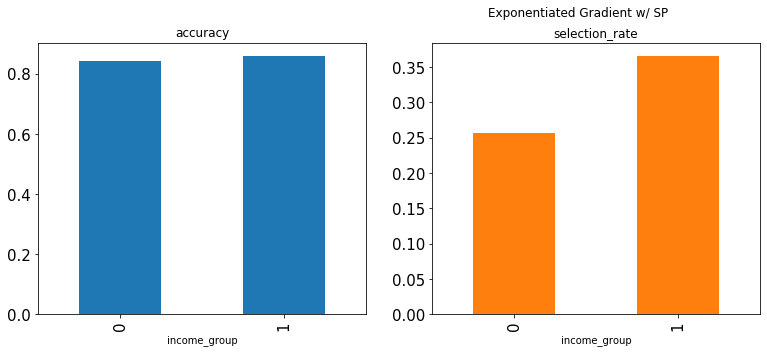

In [52]:
'''
TEST SET
'''
metric_frame_eg = MetricFrame(metric = {"accuracy": skm.accuracy_score,
                                        "selection_rate": selection_rate},
                                   sensitive_features = A_test,
                                   y_true = y_test,
                                   y_pred = y_pred_eg)

print(metric_frame_eg.overall)
print("-"*30)
print(metric_frame_eg.by_group)
print("-"*30)
print("accuracy:", "{:.5f}".format(metric_frame_eg.overall["accuracy"]))
print("accuracy diff:", "{:.5f}".format(metric_frame_eg.difference()["accuracy"]))
print("selection_rate:", "{:.5f}".format(metric_frame_eg.overall["selection_rate"]))
print("selection_rate diff:", "{:.5f}".format(metric_frame_eg.difference()["selection_rate"]))

print("-"*30)

model_summary.loc["exp_grad", "accuracy"] = metric_frame_eg.overall["accuracy"]
model_summary.loc["exp_grad", "accuracy_diff"] = metric_frame_eg.difference()["accuracy"]
model_summary.loc["exp_grad", "selection_rate"] = metric_frame_eg.overall["selection_rate"]
model_summary.loc["exp_grad", "selection_rate_diff"] = metric_frame_eg.difference()["selection_rate"]


metric_frame_eg.by_group.plot.bar(
        subplots=True, layout=[1, 3], legend=False, figsize=[20, 5],
        title='Exponentiated Gradient w/ SP', fontsize = 15)
# plt.savefig(os.path.join(save_dir_models, CITY +"exp_grad_metric"))

### 3) Grid Search (constraint: BGL)

In [53]:
kfold = KFold(2, shuffle = True, random_state = 42)

# randomly get train valid set
for train, valid in kfold.split(X_train):
    # print("CV")
    X_train_gs = X_train.loc[train]
    y_train_gs = y_train.loc[train]
    A_train_gs = A_train.loc[train]

    X_valid = X_train.loc[valid]
    y_valid = y_train.loc[valid]
    A_valid = A_train.loc[valid]

In [54]:
# get all predictors according to best grid size
acc_all = []
selection_rate_diff_all = []
mitigator = GridSearch(estimator = rf_best,
                       constraints = DemographicParity(difference_bound = best_diff),
                       grid_size = 100)

mitigator.fit(X_train_gs, y_train_gs, sensitive_features = A_train_gs)
predictors = mitigator.predictors_

In [55]:
# get dominant model on valid set
for i in range(len(predictors)):
    metric_frame = MetricFrame(metric = {"accuracy": skm.accuracy_score,
                                        "selection_rate": selection_rate},
                               sensitive_features = A_valid,
                               y_true = y_valid, 
                               y_pred = predictors[i].predict(X_valid))
    
    acc_all.append(metric_frame.overall["accuracy"])
    selection_rate_diff_all.append(metric_frame.difference()["selection_rate"])
    
# get dominant models
all_results = pd.DataFrame({"predictors:": predictors, "acc": acc_all, "diff": selection_rate_diff_all})

gs_dominant_final = []
for row in all_results.itertuples():
    '''
    want the models that have the high R^2 with low difference
    thus, we select model M if all of other models with higher R^2 than M also have higher difference than M.
    # i.e. M has the lowest difference among all of the models that have higher R^2 than it.
    '''
    difference = all_results["diff"][all_results["acc"] >= row.acc]
    if row.diff <= difference.min():
        gs_dominant_final.append(row[1])

In [56]:
# loop all of the dominant models on test set
acc_dominated = []
# acc_diff_dominated = []
selection_rate_diff_dominated = []

for i in range(len(gs_dominant_final)):
    metric_frame_dominant = MetricFrame(metric={"accuracy": skm.accuracy_score,
                                                "selection_rate": selection_rate},
                               sensitive_features = A_test,
                               y_true = y_test,
                               y_pred = gs_dominant_final[i].predict(X_test))

    
    acc_dominated.append(metric_frame_dominant.overall["accuracy"])
    selection_rate_diff_dominated.append(metric_frame_dominant.difference()["selection_rate"])

In [57]:
# calculate gs model with lowest MAE diff
gs_least_mae_idx = np.argmin(np.array(selection_rate_diff_dominated))
gs_least_mae_idx

0

In [60]:
# save model
Pkl_Filename = "grid_search_SP.pkl"
with open(os.path.join(save_dir_models, CITY + Pkl_Filename), 'wb') as file:  
    pickle.dump(gs_dominant_final[gs_least_mae_idx], file)

In [61]:
gs_dominant_model = pickle.load(open(os.path.join(save_dir_models, CITY + "grid_search_SP.pkl"), 'rb'))

accuracy         0.8266
selection_rate   0.3007
dtype: object
------------------------------
             accuracy selection_rate
income_group                        
0              0.7931         0.2667
1              0.8587         0.3333
accuracy: 0.82658
accuracy diff: 0.06562
selection_rate: 0.30068
selection_rate diff: 0.06667
------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9cc88a3c10>,
      dtype=object)

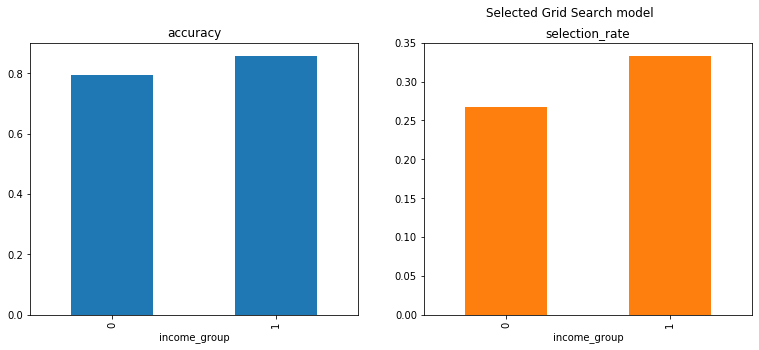

In [62]:
'''
TEST SET
'''
# gs_dominant_model = gs_dominant_final[gs_least_mae_idx]
y_pred_gs = gs_dominant_model.predict(X_test)
metric_frame_gs = MetricFrame(metric = {"accuracy": skm.accuracy_score,
                                        "selection_rate": selection_rate},
                               sensitive_features = A_test,
                               y_true = y_test,
                               y_pred = y_pred_gs)

gs_eo_diff = equalized_odds_difference(y_test, y_pred_gs, sensitive_features = A_test)

print(metric_frame_gs.overall)
print("-"*30)
print(metric_frame_gs.by_group)

print("accuracy:", "{:.5f}".format(metric_frame_gs.overall["accuracy"]))
print("accuracy diff:", "{:.5f}".format(metric_frame_gs.difference()["accuracy"]))
print("selection_rate:", "{:.5f}".format(metric_frame_gs.overall["selection_rate"]))
print("selection_rate diff:", "{:.5f}".format(metric_frame_gs.difference()["selection_rate"]))

print("-"*30)

model_summary.loc["grid_search", "accuracy"] = metric_frame_gs.overall["accuracy"]
model_summary.loc["grid_search", "accuracy_diff"] = metric_frame_gs.difference()["accuracy"]
model_summary.loc["grid_search", "selection_rate"] = metric_frame_gs.overall["selection_rate"]
model_summary.loc["grid_search", "selection_rate_diff"] = metric_frame_gs.difference()["selection_rate"]

metric_frame_gs.by_group.plot.bar(
        subplots=True, layout=[1, 3], legend=False, figsize=[20, 5],
        title='Selected Grid Search model')

# plt.savefig(os.path.join(save_dir_models, CITY+"grid_search_metric"))

Text(0.5, 1.0, 'Scatter plot of 3 models (Constraint: Equalized Odds)')

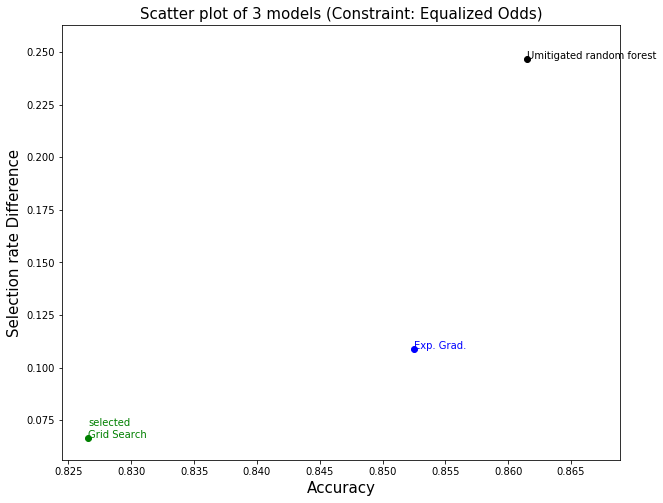

In [63]:
# plot only the dominated models

plt.figure(figsize = (10, 8))
# plt.scatter(r2_dominated, mae_diff_dominated)

# Label previous fair-unaware model
plt.scatter(metric_frame_rf_gs.overall["accuracy"], metric_frame_rf_gs.difference()["selection_rate"], color = 'black')
plt.text(metric_frame_rf_gs.overall["accuracy"], metric_frame_rf_gs.difference()["selection_rate"], "Umitigated random forest", color = 'black')

# Selected grid search model
plt.scatter(metric_frame_eg.overall["accuracy"], metric_frame_eg.difference()["selection_rate"], color = 'blue')
plt.text(metric_frame_eg.overall["accuracy"], metric_frame_eg.difference()["selection_rate"], "Exp. Grad.", color = 'blue')

# expmonentiated gradient
plt.scatter(metric_frame_gs.overall['accuracy'], metric_frame_gs.difference()["selection_rate"], color = 'green')
plt.text(metric_frame_gs.overall['accuracy'], metric_frame_gs.difference()["selection_rate"], "selected\nGrid Search", color = 'green')

plt.xlabel("Accuracy", fontsize = 15)
plt.ylabel("Selection rate Difference", fontsize = 15)
plt.title("Scatter plot of 3 models (Constraint: Equalized Odds)", fontsize = 15)
# plt.xlim((0.806, 0.811))
# plt.savefig(os.path.join(save_dir_models, CITY +"models_scatter_res"))

In [35]:
model_summary.to_csv(os.path.join(save_dir_models, CITY +"model_summary_SP.csv"))